In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train = pd.read_csv('image_tagging/train.csv') # set limit, delete "nrows" to undo
train.drop(['Name'],axis=1,inplace=True)
train.drop(train[train["Key"] == "182.429"].index, inplace=True) # invalid row
train.reset_index(drop=True, inplace=True)
train.head()

,Key,Type,normal,fire,water,grass,electric,ice,fighting,poison,ground,flying,psychic,bug,rock,ghost,dragon,dark,steel,fairy
0,110.95,"poison, ground",0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,155.408,"fire, fairy",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,360.381,"grass, psychic",0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6.142e,"fire, flying",0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,289.175,"bug, fairy",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [4]:
train.columns

Index(['Key', 'Type', 'normal', 'fire', 'water', 'grass', 'electric', 'ice',
       'fighting', 'poison', 'ground', 'flying', 'psychic', 'bug', 'rock',
       'ghost', 'dragon', 'dark', 'steel', 'fairy'],
      dtype='object')

In [5]:
TRAINING_DATASET = "/blue/rcstudents/smaley/pokegan/customsprites/blk_bg/input"
# IMAGE_SIZE = (256,256,3)
IMAGE_SIZE = (64,64,3) # try scaling down

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img(f"{TRAINING_DATASET}/{train.at[i, 'Key']}.png",target_size=IMAGE_SIZE)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 81649/81649 [01:57<00:00, 694.35it/s]


In [6]:
X.shape

(81649, 64, 64, 3)

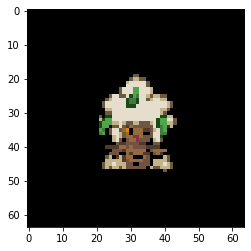

In [7]:
plt.imshow(X[2])

In [8]:
train['Type'][2]

'grass, psychic'

In [9]:
y = np.array(train.drop(['Key', 'Type'],axis=1))
y.shape

(81649, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Definition
model = Sequential()

# First Conv Block
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Conv Block
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.2))

# Third Conv Block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.2))

# Fourth Conv Block (New)
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))  # Keep padding same to preserve feature map size
model.add(Dropout(0.3))

# Fifth Conv Block (New)
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(18, activation='sigmoid'))  # Or 'softmax' for single-label classification

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 16)        448       
                                                                 
 batch_normalization_8 (Batc  (None, 62, 62, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 31, 31, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_9 (Batc  (None, 29, 29, 32)      

In [15]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[reduce_lr, early_stop])
# model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/50


2024-12-04 14:03:23.710654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-12-04 14:03:24.296427: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:03:24.297355: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:03:24.297371: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-04 14:03:24.298090: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-04 14:03:24.298129: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-04 14:03:25.185017: I tensorflow/stream_executor/cuda/c

1149/1149 [==============================] - 11s 6ms/step - loss: 0.9080 - top_k_categorical_accuracy: 0.3009 - val_loss: 0.3675 - val_top_k_categorical_accuracy: 0.3648 - lr: 0.0010
Epoch 2/50
1149/1149 [==============================] - 7s 6ms/step - loss: 0.3558 - top_k_categorical_accuracy: 0.3974 - val_loss: 0.3419 - val_top_k_categorical_accuracy: 0.3544 - lr: 0.0010
Epoch 3/50
1149/1149 [==============================] - 7s 6ms/step - loss: 0.3451 - top_k_categorical_accuracy: 0.3989 - val_loss: 0.3592 - val_top_k_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 4/50
1149/1149 [==============================] - 6s 6ms/step - loss: 0.3447 - top_k_categorical_accuracy: 0.4008 - val_loss: 0.3423 - val_top_k_categorical_accuracy: 0.4089 - lr: 0.0010
Epoch 5/50
1149/1149 [==============================] - 7s 6ms/step - loss: 0.3441 - top_k_categorical_accuracy: 0.4013 - val_loss: 0.3408 - val_top_k_categorical_accuracy: 0.3901 - lr: 0.0010
Epoch 6/50
1149/1149 [=======================

In [17]:
model.save('64_50_epoch.keras')

In [18]:
import csv

file_path = "image_tagging/all_pokemon_to_type.csv"
pokedex = {}

with open(file_path, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        key = row['Key']
        value = {col: row[col] for col in row if col != 'Key'}
        pokedex[key] = value

print(pokedex["338.287i"])

{'Type': 'dark, fairy', 'Name': 'Zoroark/Gardevoir', 'Body': '338', 'Head': '287'}


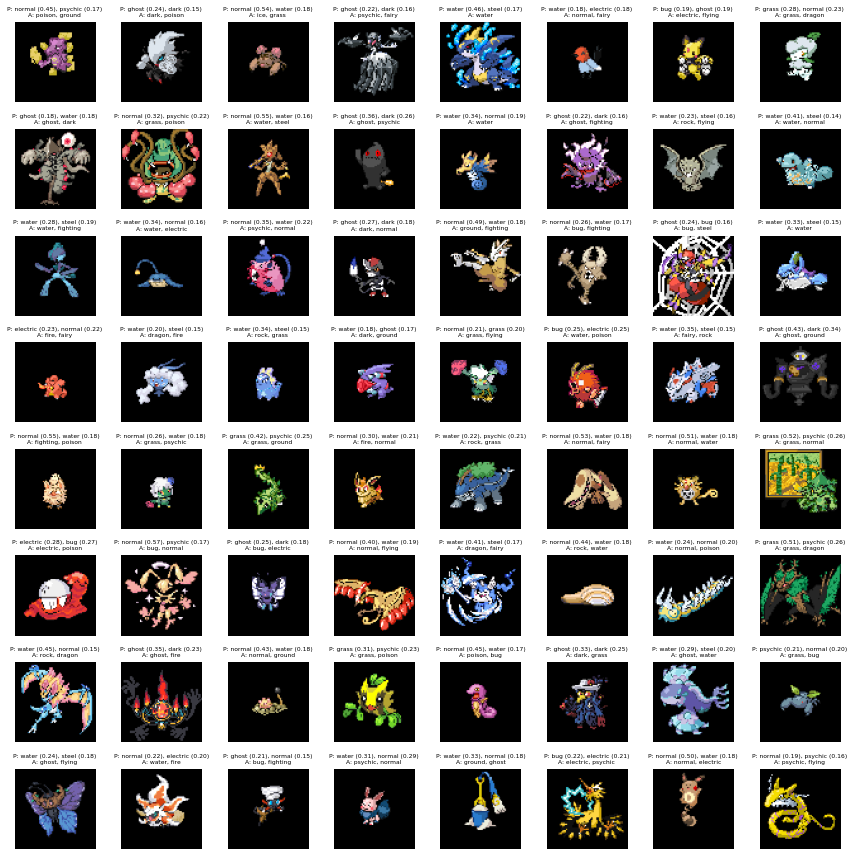

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Constants
GRID_SIZE = 8  # 8x8 grid
OUTPUT_FILE = "predictions_grid_3.png"  # Output file name

# Variables
count = 0
fig, axes = plt.subplots(GRID_SIZE, GRID_SIZE, figsize=(12, 12))
axes = axes.flatten()

# Iterate through the dataset
for idx, file_name in enumerate(os.listdir(TRAINING_DATASET)):
    if count >= GRID_SIZE * GRID_SIZE:  # Limit to 64 images
        break
    
    # Load and preprocess the image
    img_path = os.path.join(TRAINING_DATASET, file_name)
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    classes = np.array(train.columns[2:])
    
    # Make predictions
    proba = model.predict(img_array.reshape(1,64,64,3))
    top_2 = np.argsort(proba[0])[:-3:-1]  # Get top 2 predictions
    top_2_predictions = [f"{classes[i]} ({proba[0][i]:.2f})" for i in top_2]
    
    # Get ground truth
    ground_truth = pokedex[file_name[:-4]]["Type"]
    
    # Plot image in grid
    axes[idx].imshow(img)
    axes[idx].axis('off')  # Turn off axis
    axes[idx].set_title(f"P: {', '.join(top_2_predictions)}\nA: {ground_truth}", fontsize=6)
    
    count += 1

# Adjust layout and save the grid
plt.tight_layout()
plt.savefig(OUTPUT_FILE, dpi=300)
plt.show()